In [247]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

In [248]:
link = (r"C:\Users\migue\Desktop\Proyecto BEDU\Generacion_Bruta_SIE.csv")
df = pd.read_csv(link)

df[['fecha']] = pd.to_datetime(df['fecha'])

df.head()


,fecha,bca,bcs,sin
0,2010-01-01,873193.999,146750.596,17290950.83
1,2010-02-01,793243.355,134343.163,15602656.31
2,2010-03-01,871591.088,154825.632,18255692.77
3,2010-04-01,785727.001,157132.166,18585459.93
4,2010-05-01,870490.271,174237.376,20768787.08


In [249]:
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   fecha   146 non-null    datetime64[ns]
 1   bca     146 non-null    float64       
 2   bcs     146 non-null    float64       
 3   sin     146 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 4.7 KB


,bca,bcs,sin
count,1.460000e+02,146.000000,1.460000e+02
mean,9.979682e+05,199044.687214,1.965117e+07
std,1.747548e+05,36304.176070,2.297957e+06
min,7.092862e+05,125861.119000,1.449325e+07
25%,8.654446e+05,171817.357500,1.795213e+07
50%,9.342025e+05,190254.320900,1.985295e+07
75%,1.126285e+06,222936.348000,2.175807e+07
max,1.423024e+06,310344.000000,2.344321e+07


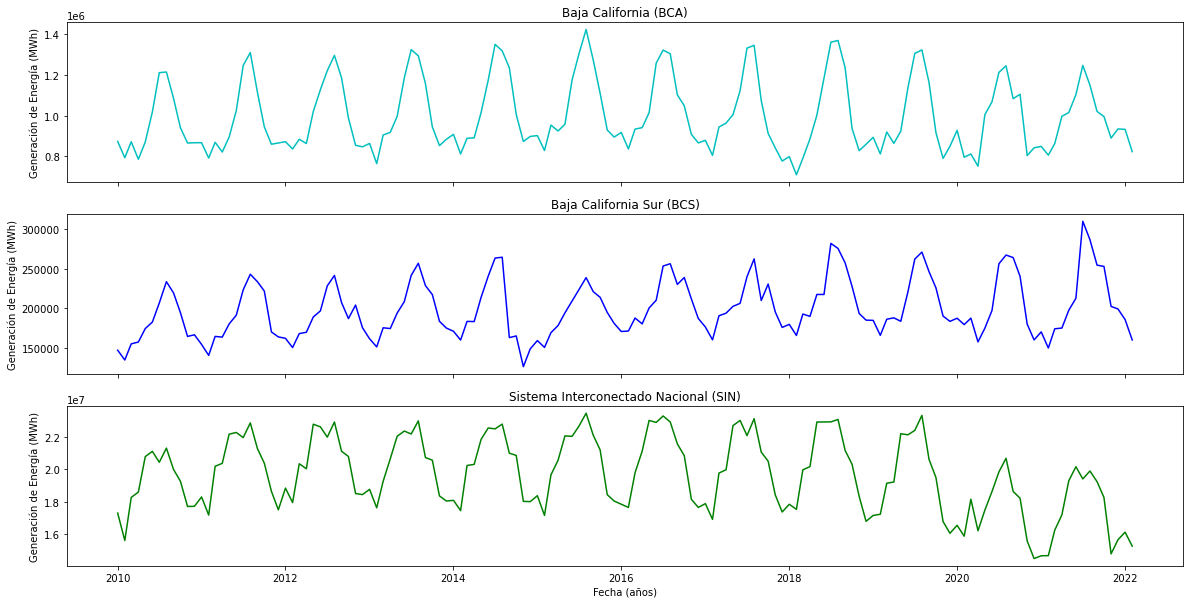

In [250]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(3, 1, sharex=True,  figsize=(20,10))

#BCA
ax[0].plot(df['fecha'], 
        df['bca'], color = 'c')

ax[1].plot(df['fecha'], 
        df['bcs'], color = 'b')

ax[2].plot(df['fecha'], 
        df['sin'], color = 'g')

ax[0].set_title('Baja California (BCA)')
ax[0].set_ylabel('Generación de Energía (MWh)')

ax[1].set_title('Baja California Sur (BCS)')
ax[1].set_ylabel('Generación de Energía (MWh)')

ax[2].set_title('Sistema Interconectado Nacional (SIN)')
ax[2].set_ylabel('Generación de Energía (MWh)')
ax[2].set_xlabel('Fecha (años)')

plt.show()




In [251]:
def transformarSerieADataset(serie, elementosPorMuestra):
    dataset = None
    salidasDataset = None
    for counter in range (len(serie)-elementosPorMuestra-1):        
        muestra = np.array([serie[counter:counter+elementosPorMuestra]])        
        salida = np.array([serie[counter+elementosPorMuestra]])
        if dataset is None:
            dataset = muestra
        else:
            dataset = np.append(dataset,muestra,axis = 0)
        if salidasDataset is None:
            salidasDataset = salida    
        else:        
            salidasDataset = np.append(salidasDataset,salida)
    return dataset, salidasDataset

In [252]:
serie = df['bca']
serie.to_numpy()

array([ 873193.999 ,  793243.355 ,  871591.088 ,  785727.001 ,
        870490.271 , 1018504.823 , 1210946.175 , 1214077.891 ,
       1084907.635 ,  940333.298 ,  865317.36  ,  866979.811 ,
        866958.701 ,  791695.35  ,  869045.354 ,  821249.244 ,
        894858.889 , 1024233.359 , 1245806.02  , 1309745.01  ,
       1114674.112 ,  944890.923 ,  859450.862 ,  865826.2   ,
        871969.673 ,  836216.079 ,  883788.375 ,  863017.96  ,
       1019960.954 , 1127504.58  , 1220960.52  , 1295617.4   ,
       1185515.569 ,  988289.32  ,  854114.858 ,  846762.114 ,
        863321.265 ,  764320.461 ,  904909.251 ,  917783.837 ,
        996449.072 , 1185100.284 , 1324097.119 , 1293681.368 ,
       1157205.892 ,  944845.517 ,  852777.997 ,  883771.639 ,
        907941.756 ,  811641.005 ,  888584.015 ,  890763.824 ,
       1014564.89  , 1173598.469 , 1350004.285 , 1317867.124 ,
       1234712.844 , 1005710.267 ,  873184.215 ,  897789.32  ,
        901812.098 ,  828750.999 ,  953253.733 ,  92441

In [253]:
X, Y = transformarSerieADataset(serie, elementosPorMuestra=10)
print(X)

[[ 873193.999  793243.355  871591.088 ... 1214077.891 1084907.635
   940333.298]
 [ 793243.355  871591.088  785727.001 ... 1084907.635  940333.298
   865317.36 ]
 [ 871591.088  785727.001  870490.271 ...  940333.298  865317.36
   866979.811]
 ...
 [ 848838.     805857.     862664.    ... 1149805.    1020363.
   995426.   ]
 [ 805857.     862664.     996947.    ... 1020363.     995426.
   889775.   ]
 [ 862664.     996947.    1014973.    ...  995426.     889775.
   934549.   ]]


In [254]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, shuffle = False, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(81, 10)
(54, 10)
(81,)
(54,)


In [255]:
lin_model = LinearRegression()
lin_model.fit(X_train, Y_train)

y_train_predict = lin_model.predict(X_train)
MSE = mean_squared_error(Y_train,y_train_predict)
print("Entrenamiento: MSE ="+str(MSE))

y_test_predict = lin_model.predict(X_test)
MSE = (mean_squared_error(Y_test, y_test_predict))
print("Pruebas: MSE ="+str(MSE))

Entrenamiento: MSE =4206078552.193061
Pruebas: MSE =6715715461.903146


In [256]:
df_predicciones = pd.DataFrame({'valor real':Y_test, 'prediccion':y_test_predict, 'diferencia':Y_test-y_test_predict})
df_predicciones = df_predicciones.reset_index(drop = True)
df_predicciones.head(10)

,valor real,prediccion,diferencia
0,1.345084e+06,1.321476e+06,23607.157190
1,1.073796e+06,1.222773e+06,-148976.995731
2,9.123681e+05,9.709733e+05,-58605.242203
3,8.415327e+05,8.112011e+05,30331.570442
4,7.768844e+05,7.922197e+05,-15335.355388
5,7.985164e+05,8.488553e+05,-50338.947519
6,7.092862e+05,8.770960e+05,-167809.777115
7,7.907403e+05,7.711244e+05,19615.839752
8,8.860515e+05,8.692243e+05,16827.219341
9,1.001922e+06,1.095360e+06,-93437.694912


In [257]:

poly_model = LinearRegression()
poly = PolynomialFeatures(degree=5)

Xpolytrain = poly.fit_transform(X_train)
Xpolytest = poly.fit_transform(X_test)

poly_model.fit(Xpolytrain, Y_train)
y_train_predict = poly_model.predict(Xpolytrain)

MSE = mean_squared_error(Y_train,y_train_predict)
print("Entrenamiento Grado = 5: MSE ="+str(MSE))

y_test_predict = poly_model.predict(Xpolytest)
MSE = (mean_squared_error(Y_test, y_test_predict))
print("Pruebas Grado = 5: MSE ="+str(MSE))




Entrenamiento Grado = 5: MSE =9.742928504012872e-18
Pruebas Grado = 5: MSE =30779924145.388336


In [258]:
df_predicciones = pd.DataFrame({'valor real':Y_test, 'prediccion':y_test_predict, 'diferencia':Y_test-y_test_predict})
df_predicciones = df_predicciones.reset_index(drop = True)
df_predicciones.head(10)


,valor real,prediccion,diferencia
0,1.345084e+06,1.273475e+06,71608.498870
1,1.073796e+06,1.209171e+06,-135374.242000
2,9.123681e+05,8.036550e+05,108713.050674
3,8.415327e+05,6.748013e+05,166731.358947
4,7.768844e+05,9.030218e+05,-126137.429380
5,7.985164e+05,8.511598e+05,-52643.403526
6,7.092862e+05,9.554816e+05,-246195.365020
7,7.907403e+05,1.016234e+06,-225493.284634
8,8.860515e+05,1.151652e+06,-265600.324055
9,1.001922e+06,1.339258e+06,-337336.124479


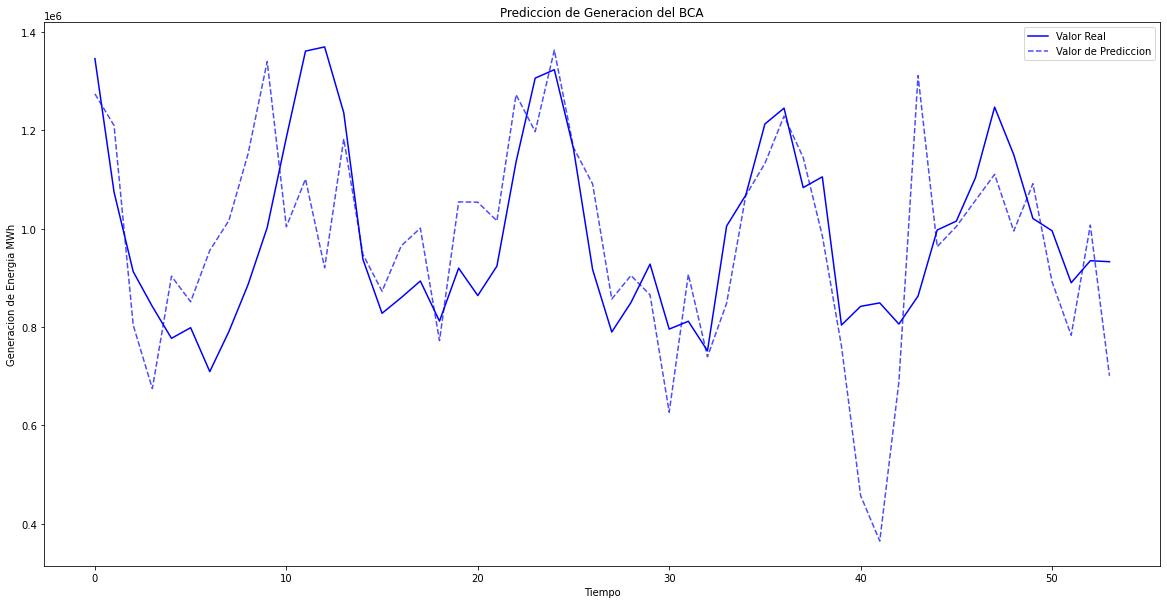

In [259]:
fig, ax = plt.subplots(figsize=(20,10))

plt.plot(df_predicciones['valor real'], label = 'Valor Real', color = 'b')
plt.plot(df_predicciones['prediccion'], label = 'Valor de Prediccion', color = 'b', alpha = 0.7, linestyle='--')

plt.title('Prediccion de Generacion del BCA')
plt.xlabel('Tiempo')
plt.ylabel('Generacion de Energia MWh')
plt.legend()
plt.show()


<AxesSubplot:>

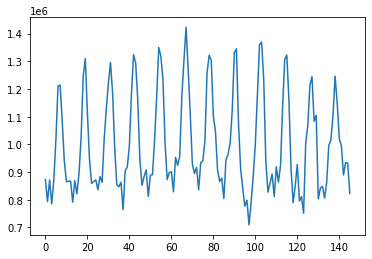

In [260]:
df
df.isna().sum()

df.describe()

df['bca'].plot()



In [275]:
df_bca = df.drop(columns = ['sin', 'bcs'])
df_bca.set_index(df_bca['fecha'], inplace=True)
df_bca.drop(columns='fecha', inplace=True)
df_bca

,bca
fecha,
2010-01-01,873193.999
2010-02-01,793243.355
2010-03-01,871591.088
2010-04-01,785727.001
2010-05-01,870490.271
...,...
2021-10-01,995426.000
2021-11-01,889775.000
2021-12-01,934549.000


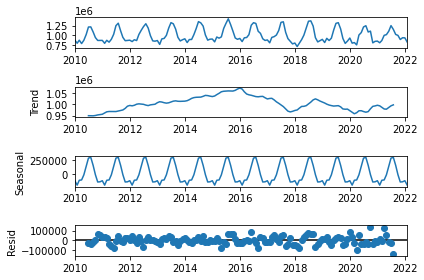

In [276]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_data = seasonal_decompose(df_bca, model="additive")
decompose_data.plot();

<AxesSubplot:xlabel='fecha'>

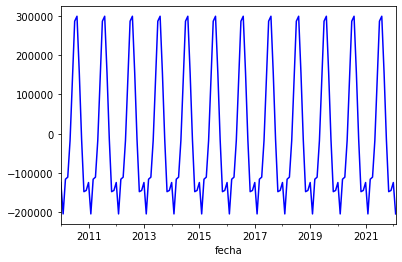

In [277]:
seasonality=decompose_data.seasonal
seasonality.plot(color='blue')

<ipython-input-278-db42e9e20a7b>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2 = plt.subplot()


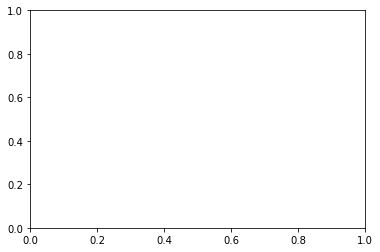

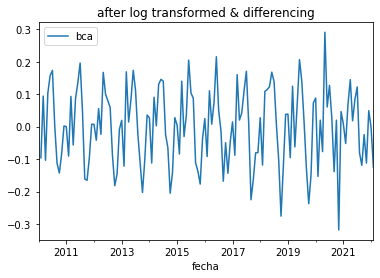

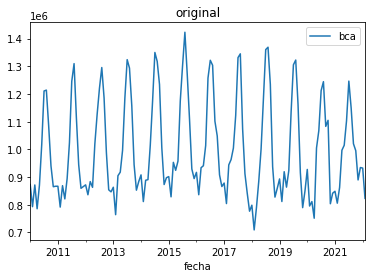

In [278]:
 log_bca = pd.DataFrame(df_bca.bca.apply(lambda x : np.log(x)))
 log_diff = log_bca - log_bca.shift()
 ax1 = plt.subplot()
 log_diff.plot(title='after log transformed & differencing');
 ax2 = plt.subplot()
 df_bca.plot(title='original'); 

In [279]:
 test = adfuller(log_diff.dropna().bca)
 print("p-value :", test[1]) 

p-value : 4.929947567609802e-11


In [280]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df_bca['bca'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()




C:\Users\migue\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\migue\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\migue\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<AxesSubplot:xlabel='fecha'>

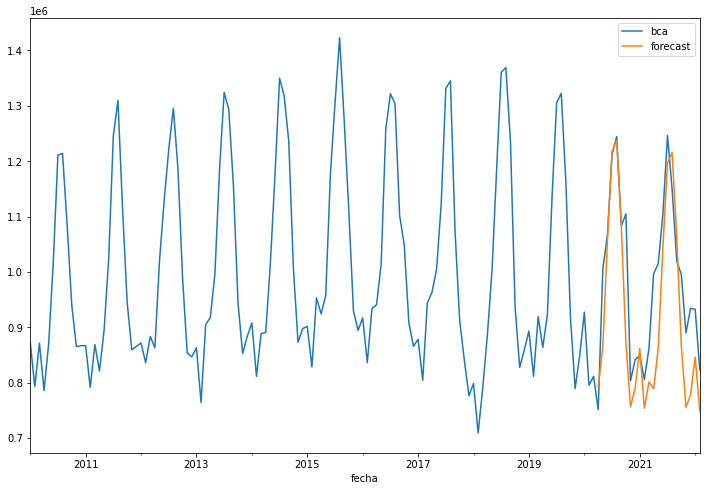

In [324]:
df_bca['forecast']=results.predict(start=123,end=146,dynamic=True)
df_bca[['bca', 'forecast']].plot(figsize=(12,8))

In [293]:
from pandas.tseries.offsets import DateOffset
pred_date=[df_bca.index[-1]+ DateOffset(months=x)for x in range(0,24)]

pred_date=pd.DataFrame(index=pred_date[1:],columns=df_bca.columns)
pred_date

,bca,forecast
2022-03-01,NaN,NaN
2022-04-01,NaN,NaN
2022-05-01,NaN,NaN
2022-06-01,NaN,NaN
2022-07-01,NaN,NaN
2022-08-01,NaN,NaN
2022-09-01,NaN,NaN
2022-10-01,NaN,NaN
2022-11-01,NaN,NaN
2022-12-01,NaN,NaN


In [294]:
df_bca_=pd.concat([df_bca,pred_date])
df_bca_

,bca,forecast
2010-01-01,873193.999,NaN
2010-02-01,793243.355,NaN
2010-03-01,871591.088,NaN
2010-04-01,785727.001,NaN
2010-05-01,870490.271,NaN
...,...,...
2023-09-01,NaN,NaN
2023-10-01,NaN,NaN
2023-11-01,NaN,NaN
2023-12-01,NaN,NaN


<AxesSubplot:>

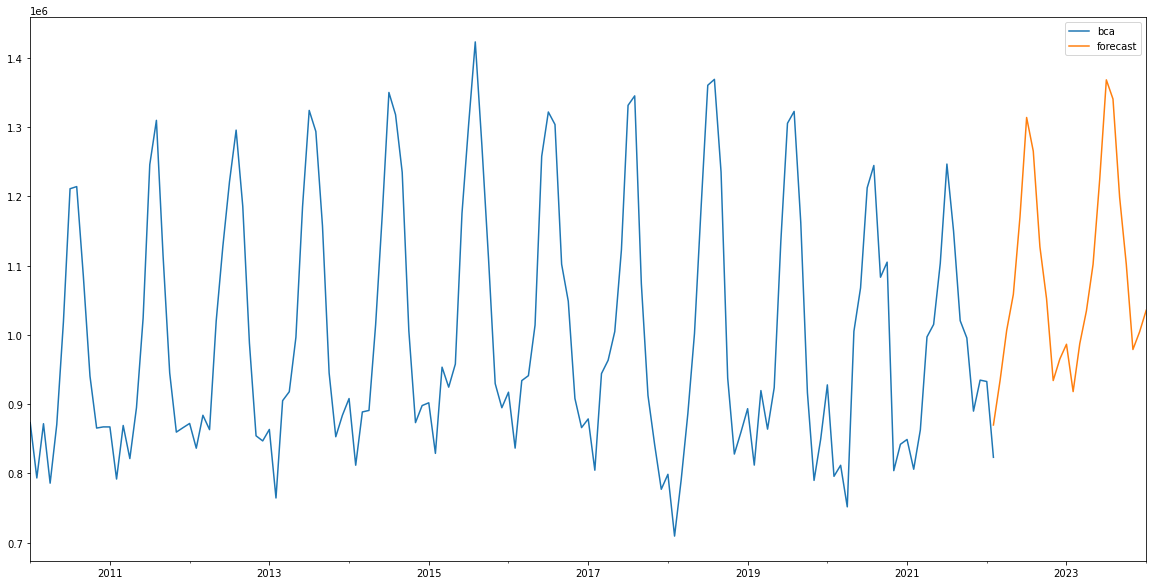

In [320]:
df_bca_['forecast'] = results.predict(start = 145, end = 168, dynamic= True)  
df_bca_
df_bca_[['bca','forecast']].plot(figsize=(20,10))

In [322]:
print(df_bca_)

                   bca      forecast
2010-01-01  873193.999           NaN
2010-02-01  793243.355           NaN
2010-03-01  871591.088           NaN
2010-04-01  785727.001           NaN
2010-05-01  870490.271           NaN
...                ...           ...
2023-09-01         NaN  1.198676e+06
2023-10-01         NaN  1.102157e+06
2023-11-01         NaN  9.787652e+05
2023-12-01         NaN  1.004113e+06
2024-01-01         NaN  1.035374e+06

[169 rows x 2 columns]
